In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Semester 5/Praktikum Manajemen Projek/dataset energi angin.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, Dropout
from keras.layers import Dense, Input
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import concatenate
from keras.layers import Bidirectional
from keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import math

In [ ]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
def ConcaveLSTM(n=100, n_steps_in=30, n_features=1) :
    inp = Input(shape=(n_steps_in, n_features), name="Input")
    stack = LSTM(n, activation="relu", return_sequences=True, input_shape=(n_steps_in, n_features), name="Stack1") (inp)
    stack = Dropout(0.2) (stack)
    stack = LSTM(n, activation='relu', return_sequences=True) (stack)
    stack = Dropout(0.2) (stack)
    stack = LSTM(n, activation='relu') (stack)

    bidir = Bidirectional(LSTM(n, activation='relu'), input_shape=(n_steps_in, n_features), name="Bidirect") (inp)

    merge = concatenate([stack, bidir])

    output = Dense(n_features, name="Output") (merge)

    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
dataraw = pd.read_csv('/content/drive/MyDrive/Semester 5/Praktikum Manajemen Projek/dataset energi angin.csv')
dataraw.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [ ]:
dataraw.tail()

,dt,MW
385561,2021-12-30 06:45:00,8140.31
385562,2021-12-30 07:00:00,8162.33
385563,2021-12-30 07:15:00,8405.11
385564,2021-12-30 07:30:00,8503.48
385565,2021-12-30 07:45:00,8403.53


In [ ]:
dataraw.describe()

,MW
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [ ]:
dataset = dataraw['MW']
dataset = dataset.dropna()
dataset.head()

,MW
0,3416.0
1,4755.0
2,4939.0
3,4939.0
4,4998.0


In [ ]:
dataset.tail()

,MW
385561,8140.31
385562,8162.33
385563,8405.11
385564,8503.48
385565,8403.53


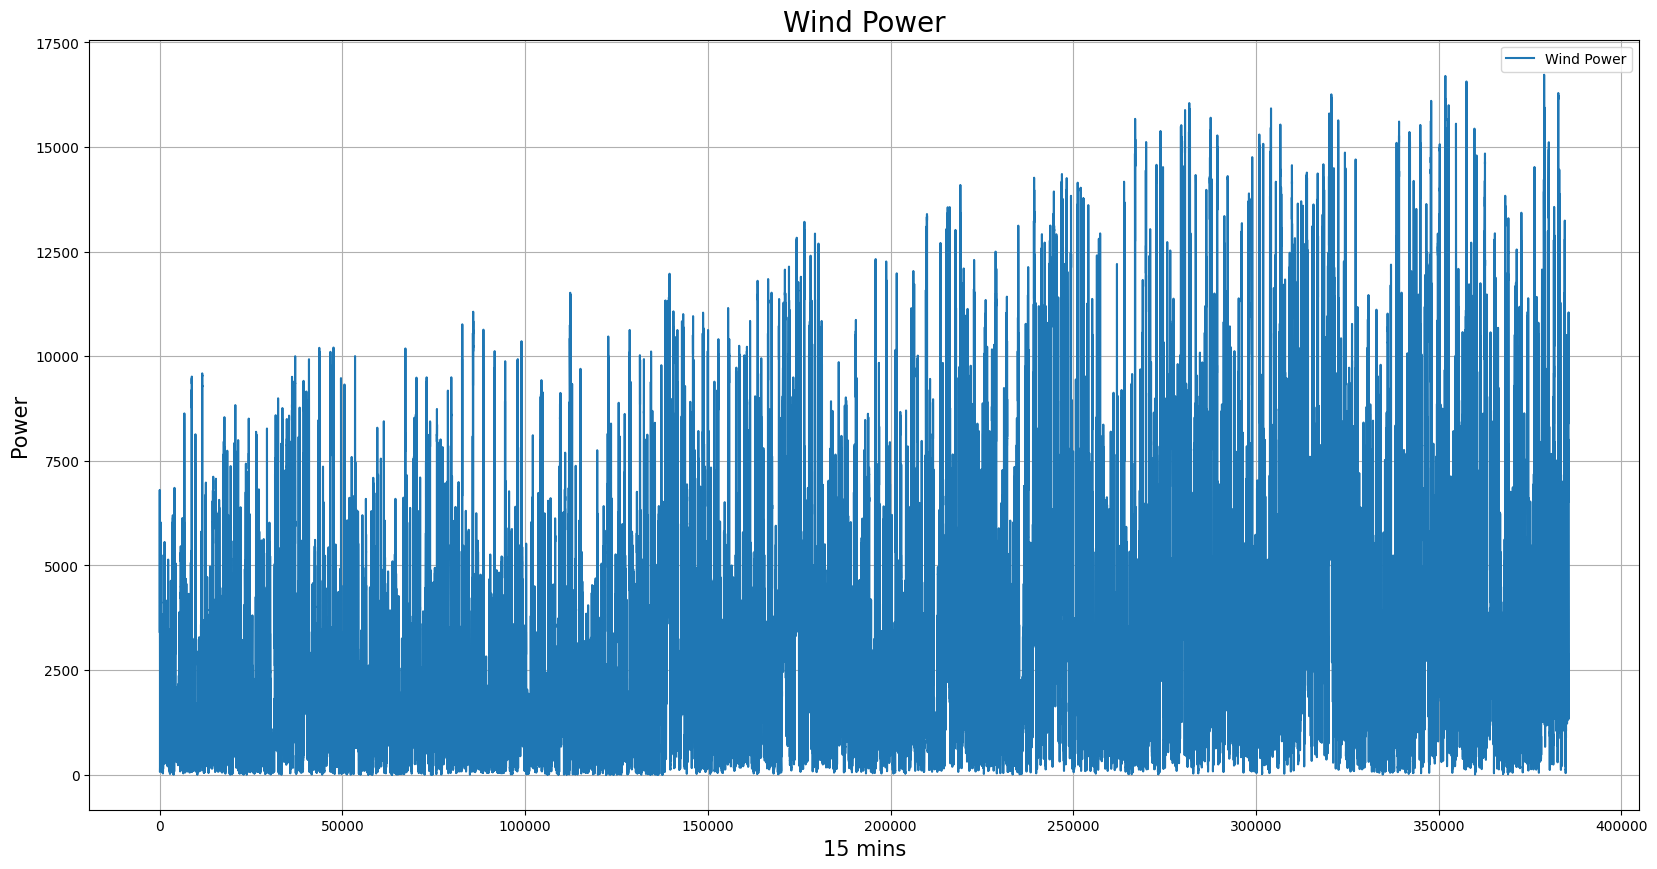

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(dataset, label='Wind Power')
plt.ylabel('Power', fontsize = 15 )
plt.xlabel('15 mins', fontsize = 15 )
plt.title('Wind Power', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
dataset.describe()

,MW
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [ ]:
dmax = dataset.max()
dmin = dataset.min()
dfx = (dataset - dmin) / (dmax - dmin)
data = dfx.to_list()[-20000:]

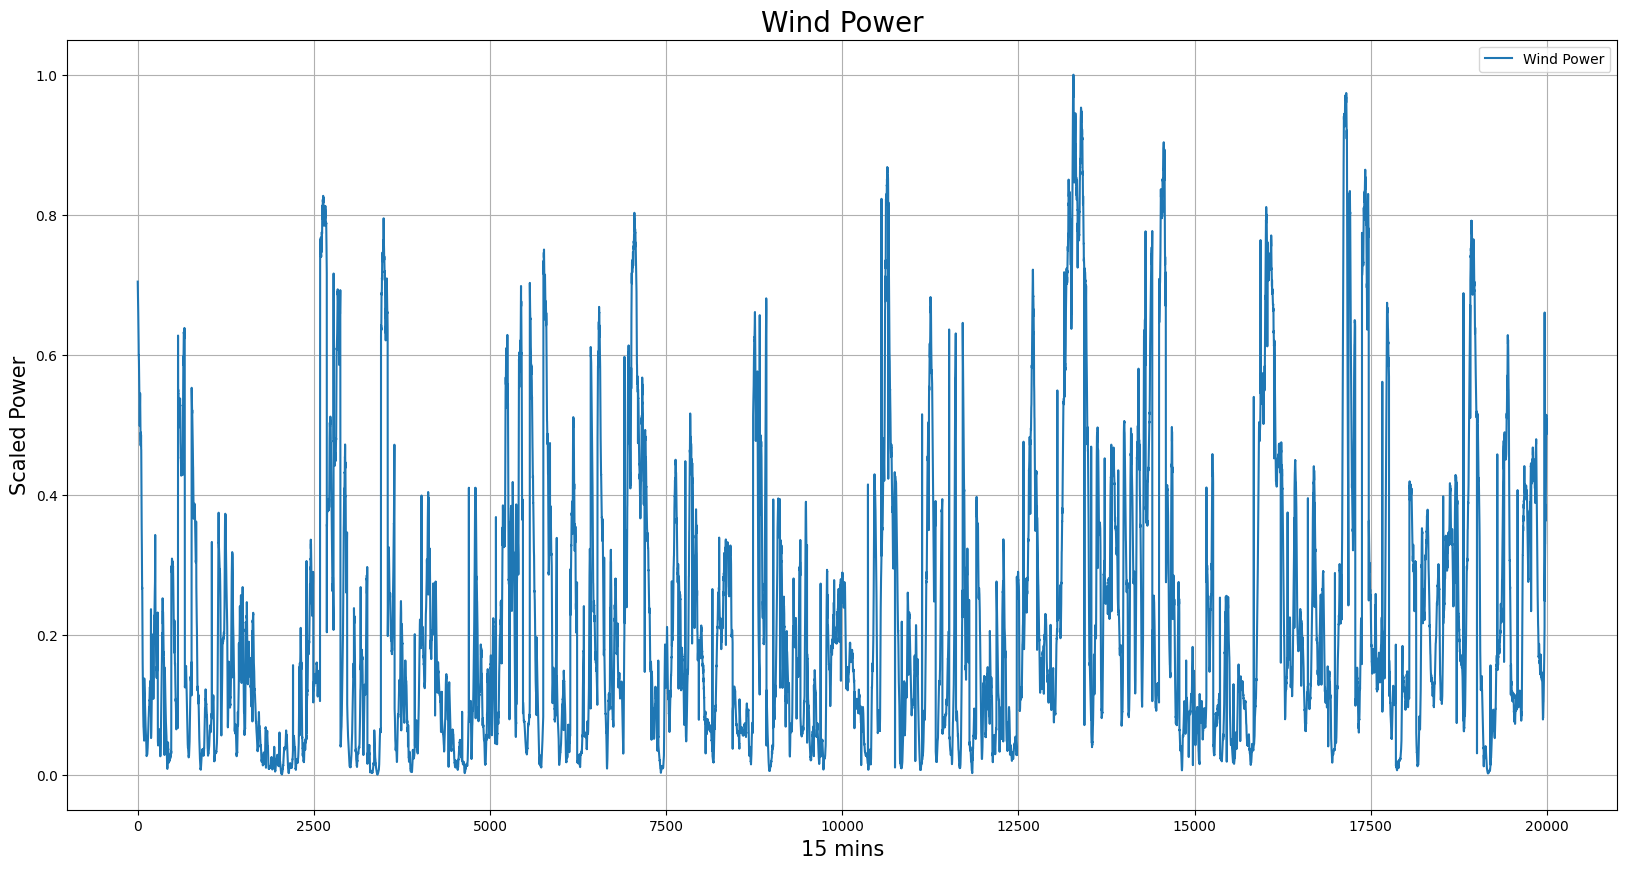

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data, label='Wind Power')
plt.ylabel('Scaled Power', fontsize = 15 )
plt.xlabel('15 mins', fontsize = 15 )
plt.title('Wind Power', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
n_steps_in = 70 # [30, 50, 70]
n_units = 300 # [100, 200, 300]
n_steps_out = 40
n_features = 1

In [ ]:
data_test = data[-n_steps_in-n_steps_out-1:]
data_train = data[:-n_steps_in-n_steps_out-1]
X, y = split_sequence(data_train, n_steps_in)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
model = ConcaveLSTM(n_units, n_steps_in, n_features)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 70, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Stack1 (LSTM)             │ (None, 70, 300)        │        362,400 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 70, 300)        │              0 │ Stack1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 70, 300)        │        721,200 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 70, 300)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 300)            │        721,200 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Bidirect (Bidirectional)  │ (None, 600)            │        724,800 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 900)            │              0 │ lstm_1[0][0],          │
│                           │                        │                │ Bidirect[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │            901 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,530,501 (9.65 MB)

 Trainable params: 2,530,501 (9.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(X, y, epochs=100, validation_split=0.2, batch_size=32, verbose=1)

Epoch 1/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - loss: 0.0075 - val_loss: 0.0015
Epoch 2/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 658s 1s/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
496/496 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/100
322/496 ━━━━━━━━━━━━━━━━━━━━ 3:28 1s/step - loss: 0.0011

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.ylabel('Loss', fontsize = 15 )
plt.xlabel('Epoch', fontsize = 15 )
plt.title('Training and Validation Loss', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
datauji = len(data_test) - n_steps_in
aktual = data_test[-datauji-1:-2]
prediksi = []

for i in range(n_steps_out):
    x_input = np.array(data_test[-n_steps_in-datauji+i:-datauji+i])
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    prediksi.append(yhat[0][0])

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(aktual, label='Actual Values')
plt.plot(prediksi, label='Predicted Values')
plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Days', fontsize = 15 )
plt.title('Actual and Predicted Values', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [ ]:
aktual

In [ ]:
prediksi

In [ ]:
RMSE = math.sqrt(mean_squared_error(aktual, prediksi))
MAE = mean_absolute_error(aktual, prediksi)
MAPE = mean_absolute_percentage_error(aktual, prediksi)
R2 = r2_score(aktual, prediksi)

print('RMSE :', RMSE)
print('MAE :', MAE)
print('MAPE :', MAPE)
print('R2 :', R2)